# Rutherford Scattering simulation

In [2]:
USE_GPU = False
if USE_GPU:
    import cupy as np
else:
    import numpy as np
    
import matplotlib.pyplot as plt
import copy
import time
import sys

## Constants

In [3]:
# general constants
c = 3.0e8
e0 = 8.854e-12
e = 1.602e-19
eA = 4.8 * 1e6 * e #alpha energy in Joule

# atomic properties
m_p = 938.272 # MeV/c^2
m_n = 939.565 # MeV/c^2
m_a = 2*m_p + 2*m_n
A_a = 4
Z_a = 2
Na = 6.02214076e23 #particles/mol
alpha = 1.0/137.035999 #fine structure constant-


rho_Au = 19.3 #g/cm^3
A_Au = 196.997 #g/mol
Dat_Au = np.power(rho_Au*Na/A_Au, -1/3)*0.01/(1000*(0.197e-15)) #gold inter atomic distance
th_Au = 0.16e-6 #gold foild thickness
#Nat_Au = int(h_Au*2/Dat_Au) #number of consecutive gold atoms
Z_Au = 79

# geometry
source_x = 0
source_y = 0
source_z = 0

## Source

In [4]:
class Source():
    def __init__(self, s_x, s_y, s_z, s_r, s_a):
        self.source_x = s_x    # x position
        self.source_y = s_y    # y position
        self.source_z = s_z    # z position
        self.source_r = s_r    # radius
        self.source_a = s_a    # activity

    def GenerateParticle(self, E_k, M, N=1):
        # kinematics
        gamma = 1.0 + E_k/M
        beta  = np.sqrt(1 - 1/(gamma*gamma))
        p     = M * gamma * beta
        
        # source point of emission (polar coordinates)
        r_s = np.sqrt(np.random.uniform(0, 1, size=(N,1))) * self.source_r
        t_s = np.random.uniform(0, 1, size=(N,1)) * 2 * np.pi
        
        # source point of emission (carthesian coordinates)
        x_s = self.source_x + r_s * np.cos(t_s)
        y_s = self.source_y + r_s * np.sin(t_s)
        z_s = self.source_z * np.ones((N,1))
        
        # versor of direction (polar coordinates)
        u_pp = np.random.uniform(0, 1, size=(N,1)) * 2 * np.pi    # momentum: phi   (0< phi <2pi  )
        u_pt = np.arccos(np.random.uniform(0, 1, size=(N,1)))     # momentum: theta (0<theta< pi/2)
        
        # versor of direction (carthesian coordinates)
        u_px = np.cos(u_pp)*np.sin(u_pt)    # momentum : x
        u_py = np.sin(u_pp)*np.sin(u_pt)    # momentum : y
        u_pz = np.cos(u_pt)                 # momentum : z
        
        # momentum of alphas (carthesian coordinates)
        px = u_px * p
        py = u_py * p
        pz = u_pz * p
        
        return [
            np.hstack((r_s,t_s)),
            np.hstack((x_s,y_s,z_s)),
            np.hstack((u_pp,u_pt)),
            np.hstack((u_px,u_py,u_pz)),
            np.hstack((px,py,pz))
        ]

In [5]:
source = Source(0,0,0,1,300)
source.GenerateParticle(4.8, m_a, 1)

[array([[0.34450825, 0.77444565]]),
 array([[0.24625754, 0.24092149, 0.        ]]),
 array([[4.82659748, 0.18671368]]),
 array([[ 0.02115454, -0.18442137,  0.98261958]]),
 array([[  4.01811128, -35.02914392, 186.63955706]])]

## Particle

In [14]:
class Particle():
    def __init__(self, source, E_k, M, N=1):
        self.source = source
        particles = source.GenerateParticle(E_k, M, N)
        self.particle_x  = particles[1][:,0]
        self.particle_y  = particles[1][:,1]
        self.particle_z  = particles[1][:,2]
        self.particle_pp = particles[2][:,0]
        self.particle_pt = particles[2][:,1]
        self.particle_px = particles[4][:,0]
        self.particle_py = particles[4][:,1]
        self.particle_pz = particles[4][:,2]
        self.particle_m  = M
        self.particle_E  = E_k*np.ones((N,))
    
    def FreeEvolutionDx(self, dx):
        self.particle_x += dx
        dt = dx*self.particle_m/self.particle_px
        self.particle_z += dt*self.particle_pz/self.particle_m
        self.particle_y += dt*self.particle_py/self.particle_m
   
    def FreeEvolutionDy(self, dy):
        self.particle_y += dy
        dt = dy*self.particle_m/self.particle_py
        self.particle_x += dt*self.particle_px/self.particle_m
        self.particle_z += dt*self.particle_pz/self.particle_m
   
    def FreeEvolutionDz(self, dz):
        self.particle_z += dz
        dt = dz*self.particle_m/self.particle_pz
        self.particle_x += dt*self.particle_px/self.particle_m
        self.particle_y += dt*self.particle_py/self.particle_m
        
    def FreeEvolutionDt(self, dt):
        self.particle_x += dt*3.0e8*self.particle_px/self.particle_m
        self.particle_y += dt*3.0e8*self.particle_py/self.particle_m
        self.particle_z += dt*3.0e8*self.particle_pz/self.particle_m
        
    def TimeEvolution(self, F, dt):
        #v(i+1)= vi +ai*dt
        #x(i+1)= xi +v(i+1)*dt 
        # x_(i+1) = x_i + t_i*px_i/M
        # px_(i+1) = px_i + F_i*t_i
        pass
    
    def Collimate(self, collimator):
        mask = collimator.Passage(self.particle_x, self.particle_y)
        self.particle_x  = self.particle_x  [mask]
        self.particle_y  = self.particle_y  [mask]
        self.particle_z  = self.particle_z  [mask]
        self.particle_pp = self.particle_pp [mask]
        self.particle_pt = self.particle_pt [mask]
        self.particle_px = self.particle_px [mask]
        self.particle_py = self.particle_py [mask]
        self.particle_pz = self.particle_pz [mask]
        self.particle_E  = self.particle_E  [mask]
        
        
    def Interact(self, target):
        alpha, beta = target.Scatter(self.particle_E, Z_a)
        # cos's
        ca = np.cos(alpha)
        cb = np.cos(beta)
        cp = np.cos(self.particle_pp)
        ct = np.cos(self.particle_pt)
        # sin's
        sa = np.sin(alpha)
        sb = np.sin(beta)
        sp = np.sin(self.particle_pp)
        st = np.sin(self.particle_pt)
        # momentum
        p  = np.sqrt(np.square(self.particle_px) + np.square(self.particle_py) + np.square(self.particle_pz))
        #rotate
        self.particle_px = (+ cp*ct*ca*sb + 1.0*sp*sa*sb - cp*st*cb) * p
        self.particle_py = (- sp*ct*ca*sb + 1.0*cp*sa*sb + sp*st*cb) * p
        self.particle_pz = (+    st*ca*sb + 0.0*   sa*sb +    ct*cb) * p    
    
    def GetTrack(self):
        return [
            self.particle_x,
            self.particle_y,
            self.particle_z
        ]
    def GetNParticles(self):
        return len(self.particle_E)
    
    def TrackCylinder(self, r, old_x, old_y, old_z):
        a = np.square(self.particle_x-old_x) + np.square(self.particle_z-old_z)
        b = old_x *  (self.particle_x-old_x) + old_z *  (self.particle_z-old_z)
        t = (-b + np.sign(self.particle_z) * np.sqrt(np.square(b) + a*r*r)) / a
        
        x_cyl = old_x + t * (self.particle_x-old_x)
        y_cyl = old_y + t * (self.particle_y-old_y)
        z_cyl = old_z + t * (self.particle_z-old_z)
        
        t_cyl = np.arccos(z_cyl/r)
        
        return [x_cyl, y_cyl, z_cyl, t_cyl]

In [15]:
particles = Particle(source, 4.8, m_a)

In [16]:
particles.particle_x

array([-0.29617226])

## Collimator

In [21]:
class Collimator():
    def __init__(self, c_x, c_y, c_z, c_w, c_h):
        #left bottom angle
        self.collimator_x = c_x    # x origin    +++++   ^z
        self.collimator_y = c_y    # y origin    +   +   |
        self.collimator_z = c_z    # z origin    o++++   x--->x
        self.collimator_w = c_w    # width
        self.collimator_h = c_h    # height
        
    def Passage(self, x, y):
        # if x>self.collimator_x and x <self.collimator_x+self.collimator_w and \
        #    y>self.collimator_y and y <self.collimator_y+self.collimator_h:
        #     return True
        # else:
        #     return False
        col_x = np.ones(x.shape) * self.collimator_x
        col_y = np.ones(y.shape) * self.collimator_y
        mask_x = np.logical_and(x>col_x, x<col_x+self.collimator_w)
        mask_y = np.logical_and(y>col_y, y<col_y+self.collimator_h)
        mask   = np.logical_and(mask_x, mask_y)
        return mask
    
class CollimatorCircular():
    def __init__(self, c_x, c_y, c_z, c_r):
        self.collimator_x = c_x    # x origin   (center)
        self.collimator_y = c_y    # y origin    
        self.collimator_z = c_z    # z origin    
        self.collimator_r = c_r    # radius
    def Passage(self, x, y):
        # if x>self.collimator_x and x <self.collimator_x+self.collimator_w and \
        #    y>self.collimator_y and y <self.collimator_y+self.collimator_h:
        #     return True
        # else:
        #     return False
        col_x = np.ones(x.shape) * self.collimator_x
        col_y = np.ones(y.shape) * self.collimator_y
        mask  = np.sqrt(np.square(col_x-x)+np.square(col_y-y))<self.collimator_r
        return mask

## Target scatter

In [22]:
# https://robolab.unex.es/wp-content/plugins/papercite/pdf/rutherford-simple-scattering.pdf
#classical treatment
#given a particle i generate 2 numbers x,y in (a, Dat/2)
# Dat is the inter atomic distance Dat=(rho*NA/A)^-1/3
#rho density A atomic mass NA avogadros number
# the impact parameter is sqrt(x2+y2)


class Target():
    def __init__(self, t_x, t_y, t_z, t_t, t_r, t_A, t_Z):
        self.target_x = t_x
        self.target_y = t_y
        self.target_z = t_z
        self.target_t = t_t #target thickness
        self.target_r = t_r #target density (rho)
        self.target_A = t_A #target atomic mass
        self.target_Z = t_Z #target effective atomic number
        self.target_D = np.power(t_r*Na/t_A, -1.0/3.0)*0.01*1.0e9
        # np.power(t_r*Na/t_A, -1.0/3.0)*0.01/(1000*(0.197e-15))#-15 giusto #target interatomic distance
    
    def Scatter(self, E, q): #energy and charge of projectyle
        a = 2*np.pi*np.random.uniform(0,1)#np.arctan(x/y)
        b = np.random.uniform(0,self.target_D/2, E.shape)
        k_2tb = 2.3651e-5/b #K is q1q2/(4*pi*e0* E_alpha) this is in nanometers
        #in mevs
        #k_2tb= q*self.target_Z / (2*E*b) # q*self.target_Z*alpha / (2*E*b)
        beta = 2*np.arctan(k_2tb) #np.pi - 2*np.arccos(k_2tb / np.sqrt(1 + np.square(k_2tb)))
        return a, beta

## Test

### Detector efficiency

In [33]:
N = 10000000#10000000
k = 20
patience = 1


source = Source(0, 0, -0.002, 0.003, 300)
#col 1 is the geometrical collimator of the source holder
col1 = Collimator(-0.0055, -0.0055, 0.0, 0.011, 0.011)
col2 = CollimatorCircular(0.0, 0.0, 0.0769, 0.0014)

n_particles = []

for i in range(k):
    if ( i % patience == 0 ):
        sys.stdout.write("\rCompleteness : "+str(round(i/k*100,1))+"%")
    particles = Particle(source, 4.8, m_a, N)
    particles.FreeEvolutionDz(0.002)
    particles.Collimate(col1)
    particles.FreeEvolutionDz(0.0769)
    particles.Collimate(col2)
    n_particles.append(particles.GetNParticles())

print("")
n_particles = np.array(n_particles)
mean_survivor = np.mean(n_particles)
print(mean_survivor)
#in the denominator the 2 factor is needed since we geenrate in the semisphere
acc_sim = mean_survivor/(2*N)*100
print("acceptance :",acc_sim , "%")

Completeness : 95.0%
1578.65
acceptance : 0.007893250000000001 %


In [34]:
#by hand
radius = 0.14
dist = 7.69
ang_solid = radius**2*np.pi/dist**2

print("Solid angles :", ang_solid)
print("acceptance   :", ang_solid/(4*np.pi)*100, "%")

Solid angles : 0.0010412458043455681
acceptance   : 0.008285970836764685 %


### Geometry and evolution: angular distribution simulation

In [14]:
if USE_GPU:
    np.cuda.Device(0).use()

In [27]:
N = 10000000#10000000
k = 100#1000
tot_gen = N*k
patience = 1

x_f  = np.array([])
y_f  = np.array([])
z_f  = np.array([])
t_f  = np.array([])
px_f = np.array([])
py_f = np.array([])
pz_f = np.array([])

#source = Source(0, 0, -0.05, 0.003, 300)
#col1 = Collimator(-0.0005, -0.0015, -0.04, 0.001, 0.003)
#col2 = Collimator(-0.0005, -0.0015,  0.00, 0.001, 0.003)
#target = Target ( 0.0, 0.0, 0.0, th_Au, rho_Au, A_Au, Z_Au)

#dcol.cik = 18.5 mm
#dcol,lam = 1mm
#-> zsorgente = 19.5
#cols = 4x7 mm
source = Source(0, 0, -0.0205, 0.003, 300)
col1 = Collimator(-0.002, -0.0035, -0.0185, 0.004, 0.007)
col2 = Collimator(-0.002, -0.0035, -0.0010, 0.004, 0.007)
target = Target ( 0.0, 0.0, 0.0, th_Au, rho_Au, A_Au, Z_Au)

start = time.time()
for i in range(k):
    if ( i % patience == 0 ):
        sys.stdout.write("\rCompleteness : "+str(round(i/k*100,1))+"%")
    particles = Particle(source, 4.8, m_a, N)
    particles.FreeEvolutionDz(0.001)
    particles.Collimate(col1)
    particles.FreeEvolutionDz(0.0185)
    particles.Collimate(col2)
    particles.FreeEvolutionDz(0.001)
    particles.Interact(target)

    x_old = copy.deepcopy(particles.particle_x)
    y_old = copy.deepcopy(particles.particle_y)
    z_old = copy.deepcopy(particles.particle_z)

    #particles.FreeEvolutionDz(0.09)
    
    # particles.FreeEvolutionDt(1e-7)

    x_f  = np.hstack((x_f, particles.particle_x ))
    y_f  = np.hstack((y_f, particles.particle_y ))
    z_f  = np.hstack((z_f, particles.particle_z ))
    px_f = np.hstack((px_f,particles.particle_px))
    py_f = np.hstack((py_f,particles.particle_py))
    pz_f = np.hstack((pz_f,particles.particle_pz))
    
    del particles
    del x_old
    del y_old
    del z_old

print("\nCompleted")  
print(time.time()-start)

t_f = np.arctan(px_f/pz_f)

Completeness : 99.0%
Completed
12.133056163787842


In [28]:
if USE_GPU:
    x_f  = np.asnumpy(x_f ) 
    y_f  = np.asnumpy(y_f ) 
    z_f  = np.asnumpy(z_f ) 
    t_f  = np.asnumpy(t_f ) 
    px_f = np.asnumpy(px_f) 
    py_f = np.asnumpy(py_f) 
    pz_f = np.asnumpy(pz_f) 

Survived:  0.9202886 %


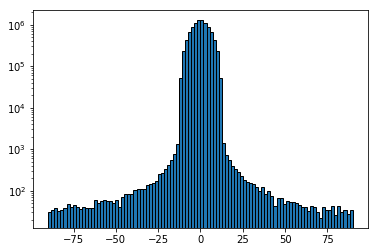

In [31]:
print("Survived: ", t_f.shape[0]/tot_gen*100, "%")

N, edges,_ = plt.hist(t_f*180/np.pi, bins=100, edgecolor="black")
plt.yscale("log")
plt.show()

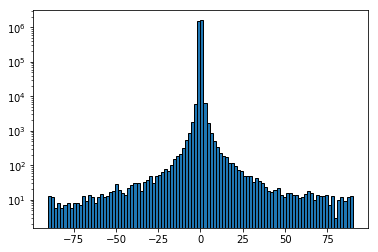

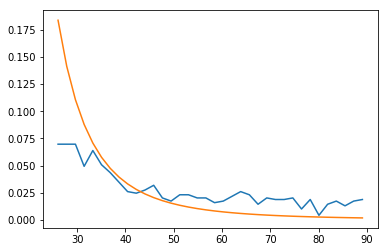

In [76]:
import numpy as npy

N, edges,_ = plt.hist(t_f*180/np.pi, bins=100, edgecolor="black", density =False)
plt.yscale('log')
plt.show()
x = (edges[1:] + edges[:-1])/2

N_filt = N[x > 25]
x_filt = x[x > 25]
y = 1.0/npy.power(npy.sin(x_filt*npy.pi/180/2),4.)
ny = npy.sum(y)
plt.plot(x_filt, N_filt/npy.sum(N_filt))
plt.plot(x_filt, y/ny)
plt.show()

#plt.yscale('log')



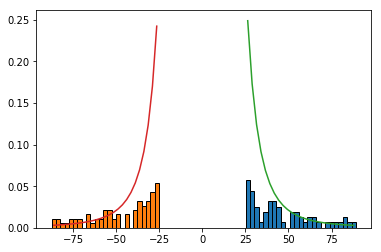

In [72]:
import numpy as npy

hdx = t_f[t_f> 25*npy.pi/180]
hsx = t_f[t_f<-25*npy.pi/180]

Ndx, edgesdx,_ = plt.hist(hdx*180/np.pi, bins=25, edgecolor="black", density=True)
Nsx, edgessx,_ = plt.hist(hsx*180/np.pi, bins=25, edgecolor="black", density=True)

xdx = (edgesdx[1:] + edgesdx[:-1])/2
xsx = (edgessx[1:] + edgessx[:-1])/2

ydx = 1.0/npy.power(npy.sin(xdx*npy.pi/180/2),4.)
ysx = 1.0/npy.power(npy.sin(xsx*npy.pi/180/2),4.)

plt.plot(xdx, ydx/npy.sum(ydx))
plt.plot(xsx, ysx/npy.sum(ysx))

#x = (edges[1:] + edges[:-1])/2
#nN = npy.linalg.norm(N)
#y = 1.0/npy.power(npy.sin(x*npy.pi/180/2),4.)
#ny = npy.linalg.norm(y)
#
#    
#plt.plot(x, N/nN)
#plt.plot(x, y/ny)
#plt.yscale("log")

### Plot of the track

In [ ]:
plt.hist2d(x_cyl, y_cyl, bins=[100,100])
#plt.hist2d(np.asnumpy(x_cyl), np.asnumpy(z_cyl), bins=[100,100])
plt.show()

In [ ]:
#N, edges,_ = plt.hist(np.asnumpy(tau_c*360.0/(2*np.pi)), bins=25, edgecolor='black')
N, edges,_ = plt.hist(tau_c*360.0/(2*np.pi), bins=25, edgecolor='black')
plt.yscale("log")
x = (edges[1:] + edges[:-1])/2

In [ ]:
import numpy as np

In [ ]:
import numpy as np
fig=plt.figure(figsize=(8, 12))

t_cyl = t_cyl[~np.isnan(t_cyl)]
z_cyl = z_cyl[~np.isnan(z_cyl)]

plt.subplot(2,1,1)
plt.hist2d(t_cyl, z_cyl, bins=[50,1])
#plt.hist2d(np.asnumpy(t_cyl), np.asnumpy(z_cyl), bins=[50,1])

plt.subplot(2,1,2)
plt.hist(t_cyl*360.0/(2*np.pi)-90.0, bins=50, edgecolor='black')
#plt.hist(np.asnumpy(t_cyl*360.0/(2*np.pi)-90.0), bins=50, edgecolor='black')
plt.yscale('log')
plt.show()

In [ ]:
plt.hist(t_cyl*360.0/(2*np.pi), bins=50, edgecolor='black')
#plt.hist(np.asnumpy(t_cyl*360.0/(2*np.pi)-90.0), bins=50, edgecolor='black')
plt.yscale('log')
plt.show()

In [ ]:
test_theta = np.arctan(py_cy/pz_cy) * 180/np.pi
plt.hist(test_theta, bins=50, edgecolor='black')
#plt.hist(np.asnumpy(t_cyl*360.0/(2*np.pi)-90.0), bins=50, edgecolor='black')
plt.yscale('log')
plt.show()

In [ ]:
import cupy as cp
import numpy as np

N, edges, _ = plt.hist(cp.asnumpy(t_cyl*360.0/(2*np.pi)-90.0), bins=50, edgecolor='black')
plt.yscale("log")
plt.show()

In [ ]:
x = (edges[1:] + edges[:-1])/2
nN = np.linalg.norm(N)
y = 1.0/np.power(np.sin(x*np.pi/180/2),4.)
ny = np.linalg.norm(y)
plt.plot(x, N/nN)
plt.plot(x, y/ny)
plt.yscale("log")

### 3D view

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations


fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')

def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

axisEqual3D(ax)        

ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)

ax.azim = -160
ax.elev = 30
# draw sphere
# u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
# x = np.cos(u)*np.sin(v)
# y = np.sin(u)*np.sin(v)
# z = np.cos(v)
# ax.plot_wireframe(x, y, z, color="r")

# draw a point
ax.scatter([0], [0], [0], color="g", s=100)

# draw a vector
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


class Arrow3D(FancyArrowPatch):

    def _init_(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch._init_(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

x = Arrow3D([-1, 1],  [0, 0],  [0, 0], mutation_scale=20, lw=1, arrowstyle="-|>", color="k")
y = Arrow3D( [0, 0], [-1, 1],  [0, 0], mutation_scale=20, lw=1, arrowstyle="-|>", color="k")
z = Arrow3D( [0, 0],  [0, 0], [-1, 1], mutation_scale=20, lw=1, arrowstyle="-|>", color="k")

u_x =   0#np.cos(np.pi/4)
u_y =   1#np.cos(np.pi/4)
u_z =   0.3#np.cos(np.pi/4)

t  = np.pi/4
a  = np.pi/4
ct = np.cos(t) 
st = np.sin(t) 
ca = np.cos(a)
sa = np.sin(a)

def Xr(u_x, u_y, u_z, t):
    v_x = + u_x*1 + u_y*0         + u_z*0
    v_y = + u_x*0 + u_y*np.cos(t) + u_z*1 - u_z*np.sin(t)
    v_z = + u_x*0 + u_y*np.sin(t) + u_z*0 + u_z*np.cos(t)
    return v_x, v_y, v_z

def Yr(u_x, u_y, u_z, t):
    v_x = + u_x*np.cos(t) + u_y*0 + u_z*np.sin(t)
    v_y = + u_x*0         + u_y*1 + u_z*0
    v_z = - u_x*np.sin(t) + u_y*0 + u_z*np.cos(t)
    return v_x, v_y, v_z

def Zr(u_x, u_y, u_z, t):
    v_x = + u_x*np.cos(t) - u_y*np.sin(t) - u_z*0
    v_y = + u_x*np.sin(t) + u_y*np.cos(t) + u_z*0
    v_z = + u_x*0         + u_y*0         + u_z*1
    return v_x, v_y, v_z
    

# y rotation for alpha z rotation tau
v_x, v_y, v_z = Yr(u_x,u_y,u_z, np.pi/4)
w_x, w_y, w_z = Zr(v_x,v_y,v_z, np.pi/4)

u = Arrow3D([0, u_x], [0, u_y], [0, u_z], mutation_scale=20, lw=1, arrowstyle="->",  color="r")
v = Arrow3D([0, v_x], [0, v_y], [0, v_z], mutation_scale=20, lw=1, arrowstyle="-|>", color="b")
w = Arrow3D([0, w_x], [0, w_y], [0, w_z], mutation_scale=20, lw=1, arrowstyle="-|>", color="c")

ax.add_artist(x)
ax.add_artist(y)
ax.add_artist(z)
ax.add_artist(u)
ax.add_artist(v)
ax.add_artist(w)

ax.set_xlabel('$X$', fontsize=20)
ax.set_ylabel('$Y$', fontsize=20)
ax.set_zlabel('$Z$', fontsize=20)
ax.auto_scale_xyz([-1, 1], [-1, 1], [-1, 1])
plt.show()

array([False, False,  True])